To combine project 4 and 5 together, I deal with several things:
1. align different data formats, such as mpimg.imread and cv2.imread, will give you different color channels and differnt scales, reading jpg vs png make a different, resizing image make a difference. 
2. forget about the hog way to identify cars, use deep learning. My project 5 was trained in BGR format, so I convert the data and retrained from scratch.
3. show the location of the car.

Final video is uploaded at https://youtu.be/w15GpupQusM

Although it is not perfect with occationally false positive and false negative, it is a good starting point.

In [59]:
import matplotlib.pyplot as plt
% matplotlib inline

In [60]:
import os
import cv2
folder = 'project_video'

if not os.path.isdir(folder):
    os.mkdir(folder)  # make folder
    vidcap = cv2.VideoCapture('project_video.mp4')  # 1260 images = 50 s * 25 fps
    while True:
        success,image = vidcap.read()
        if not success:
            break
        cv2.imwrite(os.path.join(folder,"{:d}.jpg".format(count)), image)     # save frame as JPEG file
files = os.listdir(folder)        
print("{} images are extacted in {} folder.".format(len(files),folder))

1260 images are extacted in project_video folder.


# test lane function

In [68]:
from sklearn.externals import joblib
import cv2
import numpy as np
M, Minv = joblib.load("Ptransform.p")
fit1,fit2 = joblib.load("fit.p")
red_min, red_max = 210, 255
vertices = np.array([[(200,700),(500, 400), (800, 400), (1200,700)]], dtype=np.int32)
image_width, image_height = 1280,720
ploty = np.linspace(0, image_height-1, image_height)
margin = 100
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

def curvature(fit, y):
    A, B = fit[0], fit[1]
    return (1+(2*A*y+B)**2)**1.5/np.absolute(2*A)

def pipeline(image): 
    "must be RGB image"
    global fit1,fit2
    # detailed explanation see section 3.3
    r = image[:,:,0]
    red_binary = np.zeros((image_height,image_width),dtype=float)
    red_binary [(r> red_min)& (r < red_max)] = 1
    mask = np.zeros((image_height,image_width),dtype=float)
    cv2.fillPoly(mask, vertices, 255)
    masked_binary = cv2.bitwise_and(mask,red_binary)
    warped = cv2.warpPerspective(masked_binary, M, (image_width, image_height))

    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    fitx1 = fit1[0]*(nonzeroy**2) + fit1[1]*nonzeroy + fit1[2]
    fitx2 = fit2[0]*(nonzeroy**2) + fit2[1]*nonzeroy + fit2[2]
    lane1_index = ((nonzerox > fitx1 - margin) & (nonzerox < fitx1 + margin))
    lane2_index = ((nonzerox > fitx2 - margin) & (nonzerox < fitx2 + margin))
    x1,y1 = nonzerox[lane1_index], nonzeroy[lane1_index]
    x2,y2 = nonzerox[lane2_index], nonzeroy[lane2_index]
    fit1 = np.polyfit(y1, x1, 2)
    fit2 = np.polyfit(y2, x2, 2)
    # calibrated coefficients
    fitx1 = fit1[0]*ploty**2 + fit1[1]*ploty + fit1[2]  
    fitx2 = fit2[0]*ploty**2 + fit2[1]*ploty + fit2[2]
    fit1_cal = np.polyfit(ploty*ym_per_pix, fitx1*xm_per_pix, 2)
    fit2_cal = np.polyfit(ploty*ym_per_pix, fitx2*xm_per_pix, 2)
    curv1 = curvature(fit1_cal, 30)
    curv2 = curvature(fit2_cal, 30)
    off_center = (fitx1[-1]+fitx2[-1]-1280)/2 *xm_per_pix
    text1 = "Lane Curvatures, left: {0:.0f} m, right: {1:.0f} m".format(curv1,curv2)
    text2 = "Car is right to the center by {0:.2f} m".format(off_center)
    texted_image = np.copy(image)
    cv2.putText(img = texted_image, text= text1, org=(50,50),
                          fontFace=3, fontScale=1, color=(0,0,255), thickness=2)
    cv2.putText(img = texted_image, text= text2, org=(50,100),
                          fontFace=3, fontScale=1, color=(0,0,255), thickness=2)

    color_warp = np.zeros((720,1280,3)).astype(np.uint8)
    pts1 = np.array([np.transpose(np.vstack([fitx1, ploty]))])
    pts2 = np.array([np.flipud(np.transpose(np.vstack([fitx2, ploty])))])
    pts = np.hstack((pts1, pts2))
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    newwarp = cv2.warpPerspective(color_warp, Minv, (image_width, image_height))
    result = cv2.addWeighted(texted_image, 1, newwarp, 0.3, 0)

    return result

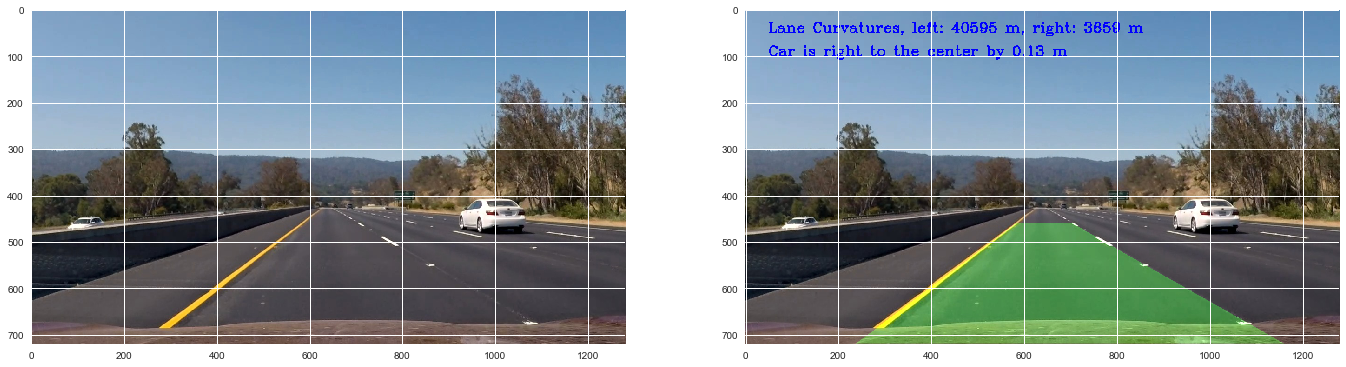

In [69]:
import matplotlib.image as mpimg
image = mpimg.imread("project_video/411.jpg") # shape (540, 960, 3)
lane_image = pipeline(image)
plt.figure(figsize=(20,10))
plt.subplot(221)
plt.imshow(image)
plt.subplot(222)
plt.imshow(lane_image)
plt.tight_layout()
plt.show()

# test detection function

In [70]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    imcopy = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy
    
def slide_window(img, x_start,x_stop, y_start,y_stop, 
                    xy_window, xy_overlap):

    # Overlap pixels, which slows down the window moving
    x_overlap = np.int(xy_window[0]*(xy_overlap[0]))
    y_overlap = np.int(xy_window[1]*(xy_overlap[1]))    
    # Compute the effective moving pixels per step
    nx_pix_per_step = xy_window[0]- x_overlap
    ny_pix_per_step = xy_window[1]- y_overlap
    # Compute the number of windows in x/y
    nx_windows = np.int((x_stop - x_start-x_overlap)/nx_pix_per_step) 
    ny_windows = np.int((y_stop - y_start-y_overlap)/ny_pix_per_step) 

    window_list = []
    for y in range(ny_windows):
        for x in range(nx_windows):       
            startx = x * nx_pix_per_step + x_start
            endx = startx + xy_window[0]
            starty = y * ny_pix_per_step + y_start
            endy = starty + xy_window[1]      
            window_list.append(((startx, starty), (endx, endy)))
    return window_list

Exception ignored in: <bound method VideoFileClip.__del__ of <moviepy.video.io.VideoFileClip.VideoFileClip object at 0x1349ab550>>
Traceback (most recent call last):
  File "/Users/yuchaojiang/anaconda2/envs/car/lib/python3.5/site-packages/moviepy/video/io/VideoFileClip.py", line 90, in __del__
    del self.reader
AttributeError: reader


0.441103 0.558897
vehicle 1: upperLeft position=(860, 400), size=(95, 95)


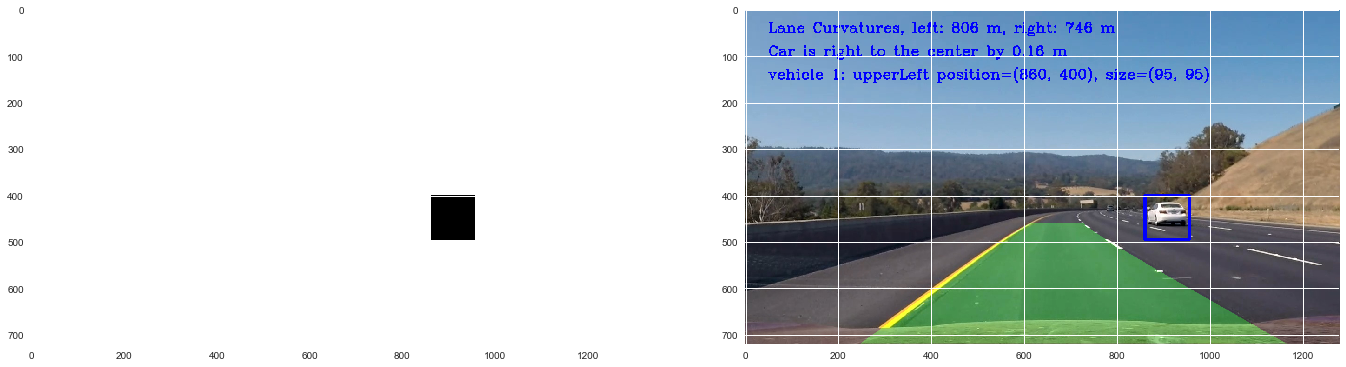

In [100]:
from keras.models import load_model
from scipy.ndimage.measurements import label
image = mpimg.imread("project_video/665.jpg")/255.0 # jpg in 0-255 scale, png in 0-1 scale

model = load_model('model.h5')
windows = slide_window(image, 500,1280, 400, 680, 
                    xy_window=(96, 96), xy_overlap=(0.75, 0.75))

on_windows = []
for window in windows:
    win_img = image[window[0][1]:window[1][1], window[0][0]:window[1][0]]
    rgb64 = cv2.resize(win_img, (64,64))
    no, yes = model.predict(rgb64.reshape(-1,64,64,3))[0]
    if yes > 0.55:
        print(no,yes)
        on_windows.append(window)

heat = np.zeros((image_height,image_width),dtype=float)
for box in on_windows:
    heat[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
#threshold = 2
#heat[heat <= threshold] = 0

labels,num  = label(heat)
img = mpimg.imread("project_video/665.jpg") # BGR
cnt = 0
nx, ny = 1,1
for car_number in range(1, num+1):
    nonzero = (labels == car_number).nonzero() 
    boxpoint1 = (min(nonzero[1]), min(nonzero[0]))  # (x,y)
    boxpoint2 = (max(nonzero[1]), max(nonzero[0])) 
    width, height = boxpoint2[0]-boxpoint1[0],boxpoint2[1]-boxpoint1[1]
    cnt += 1
    text_pos = 100 + cnt*50
    cv2.rectangle(img, boxpoint1, boxpoint2, (0,0,255), 6)
    text = "vehicle {}: upperLeft position={}, size={}".format(cnt,boxpoint1,(width,height))
    cv2.putText(img = img, text= text, org=(50,text_pos),
                      fontFace=3, fontScale=1, color=(0,0,255), thickness=2)
    print("vehicle {}: upperLeft position={}, size={}".format(cnt,boxpoint1,(width,height)))

lane_image = pipeline(img)   

plt.figure(figsize=(20,10))
plt.subplot(221)
plt.imshow(heat)

plt.subplot(222)
plt.imshow(lane_image)
plt.tight_layout()
plt.show()

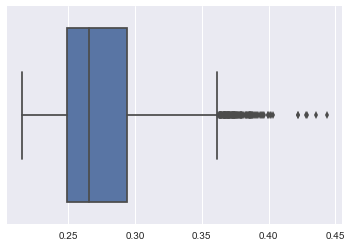

In [92]:
sns.boxplot(rgb64)

# make video

In [101]:
def pipeline_for_all(image):

    scaled_image = image/255.0    
    on_windows = []  # collect positive windows
    for window in windows:
        win_img = scaled_image[window[0][1]:window[1][1], window[0][0]:window[1][0]]
        rgb64 = cv2.resize(win_img, (64,64))
        no, yes = model.predict(rgb64.reshape(-1,64,64,3))[0]
        if yes > 0.8:
            #print(no,yes)
            on_windows.append(window)

    heat = np.zeros((image_height,image_width),dtype=float)
    for box in on_windows:
        heat[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
        
    #threshold = 2
    #heat[heat <= threshold] = 0

    labels,num  = label(heat)
    text_img = cv2.cvtColor(image,cv2.COLOR_RGB2BGR)  # BGR in 0-255 scale
    cnt = 0
    #nx, ny = 3,2
    for car_number in range(1, num+1):
        nonzero = (labels == car_number).nonzero() 
        boxpoint1 = (min(nonzero[1]), min(nonzero[0]))  # (x,y)
        boxpoint2 = (max(nonzero[1]), max(nonzero[0])) 
        # print(boxpoint1,boxpoint2)
        width, height = boxpoint2[0]-boxpoint1[0],boxpoint2[1]-boxpoint1[1]
        #if width > 96*(1+0.25*nx) or height > 96*(1+0.25*ny):

        cnt += 1
        text_pos = 100 + cnt*50
        cv2.rectangle(text_img, boxpoint1, boxpoint2, (0,0,255), 6)
        text = "vehicle {}: upperLeft position={}, size={}".format(cnt,boxpoint1,(width,height))
        cv2.putText(img = text_img, text= text, org=(50,text_pos),
                          fontFace=3, fontScale=1, color=(0,0,255), thickness=2)
    
    RGB_img = cv2.cvtColor(text_img,cv2.COLOR_BGR2RGB)
    final_image = pipeline(RGB_img)
    return final_image

In [ ]:
from moviepy.editor import VideoFileClip
output = 'project_output.mp4'
clip = VideoFileClip('project_video.mp4').fl_image(pipeline_for_all)
%time clip.write_videofile(output, audio=False)

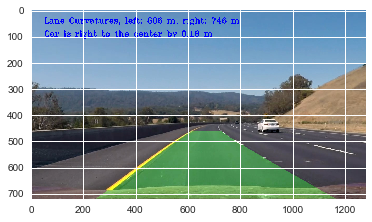

In [98]:
test_image = pipeline_for_all(mpimg.imread("project_video/665.jpg"))
plt.imshow(test_image)